In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from sklearn.metrics import r2_score
from scipy.stats import norm
import scipy.stats as sts
import torch
from model import MLP
import json

plt.style.use(["grid", "science", "no-latex"])

with open("training_loss.npy", "rb") as f:
    training_loss = np.load(f)
with open("validation_loss.npy", "rb") as f:
    validation_loss = np.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("last_config") as f:
    config = json.load(f)

model = MLP(
    input_dim=config["input_dim"],
    output_dim=config["output_dim"],
    hidden_dim=config["hidden_dim"],
    depth=config["depth"],
    normalization=config["normalization"],
).to(device)
model.load_state_dict(torch.load("checkpoint.pth", map_location=device))
model.eval()

MLP(
  (input_layer): Linear(in_features=6, out_features=400, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=400, out_features=400, bias=True)
  )
  (output_layer): Linear(in_features=400, out_features=1, bias=True)
  (activation): SiLU()
  (normalization): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
)

In [7]:
# summary statistics utilities
def residuals_diagnostic(
    y_true,
    y_pred,
    resid_density=norm.pdf,
    resid_density_name="Gaussian",
    density_range=None,
):
    residuals = y_true - y_pred
    r2 = r2_score(y_true, y_pred)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    ax1.scatter(y_pred, residuals, s=20, color="white", edgecolors="k")

    ax1.set_title("Residuals vs Fitted values")
    ax1.set_xlabel("fitted values")
    ax1.set_ylabel("residuals")

    ax2.hist(
        residuals,
        bins=100,
        edgecolor="k",
        density=True,
        color="white",
        label="Validation residuals",
    )
    if density_range is None:
        density_range = (-0.010, 0.007)
    mean = residuals.mean()
    std = residuals.std()
    if resid_density == sts.laplace.pdf:
        std = std / np.sqrt(2)
    ax2.plot(
        np.linspace(density_range[0], density_range[1], num=200),
        resid_density(
            np.linspace(density_range[0], density_range[1], num=200),
            loc=mean,
            scale=std,
        ),
        lw=1.5,
        linestyle="--",
        color="black",
        label=f"Fitted {resid_density_name}",
    )
    # ax2.set_xlim(left=-0.0075, right=0.005)
    ax2.set_xlabel("residuals")
    ax2.set_ylabel("density")
    ax2.legend(loc=0)
    ax2.set_title("Residuals distribution")

    ax3.scatter(
        y_true,
        y_pred,
        s=20,
        edgecolor="k",
        color="white",
        label=rf"$R^2$={r2:.5f}",
    )
    ax3.legend(loc=0)
    ax3.set_title("Fitted values vs Target values")
    ax3.set_xlabel("target values")
    ax3.set_ylabel("fitted values")
    fig.tight_layout()
    plt.show()
    plt.close()

In [3]:
with open("X_valid.npy", "rb") as f:
    X_valid = np.load("X_valid.npy")
with open("Y_valid.npy", "rb") as f:
    Y_valid = np.load("Y_valid.npy")

X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)

predictions = model(X_valid).flatten().detach().to("cpu").numpy()

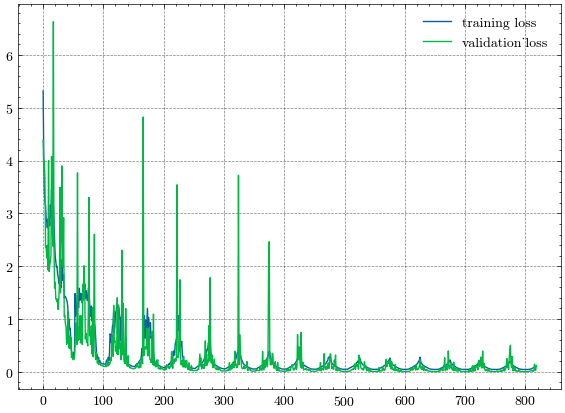

In [4]:
fig = plt.figure(figsize=(7, 5))

plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation_loss")
plt.legend(loc=0)
plt.show()

In [5]:
validation_loss.min()

0.002559122396633029

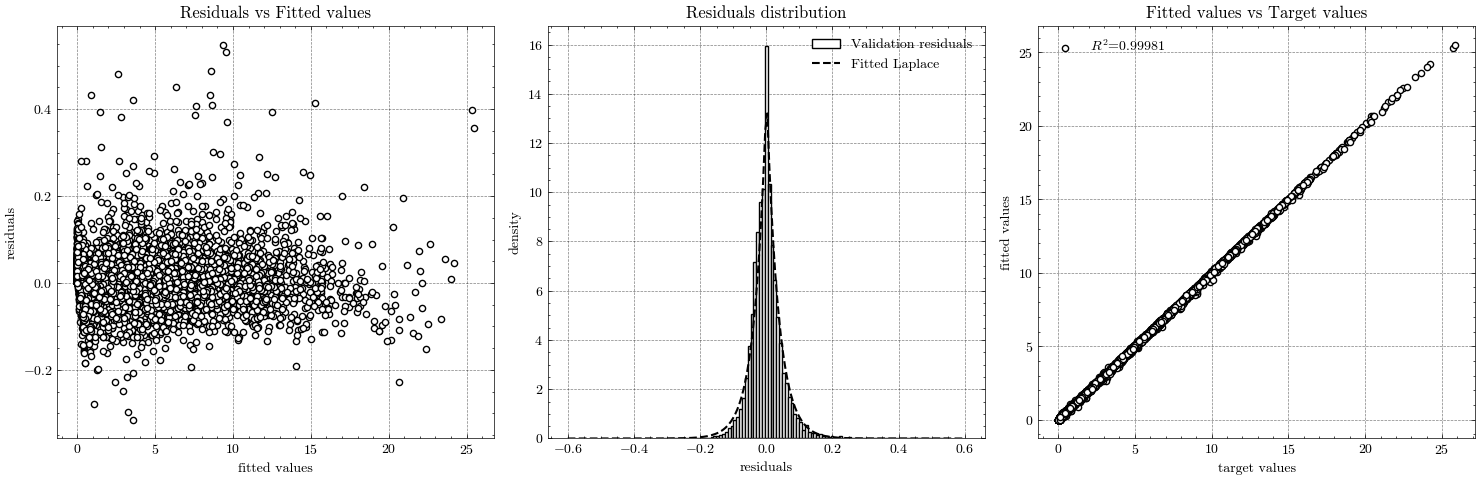

In [8]:
residuals_diagnostic(
    Y_valid,
    predictions,
    resid_density=sts.laplace.pdf,
    resid_density_name="Laplace",
    density_range=(-0.6, 0.6),
)